<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/images_ferramenta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/ferramenta/"
# images-train.tar.gz
# images-val.tar.gz

In [ ]:
os.chdir(path)

In [ ]:
# import tarfile

# with tarfile.open('images-val.tar.gz', 'r:gz') as tar_ref:
#     tar_ref.extractall('validImages')

# Pre Processing

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.num_classes = len(self.dataset.classes)

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label
    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1
                
    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/ferramenta/trainingImages/images-train'
dataset = FragmentaDataset(data_dir)

In [ ]:
batch_size = 32
num_workers = 3
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Loading ResNet-50

In [ ]:
resnet = models.resnet50(pretrained=True)
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 242MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Fine Tuning

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 52


In [ ]:
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer and set the learning rate
learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

num_epochs = 15
training_loss = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

for epoch in range(num_epochs):
    # Set the model to training mode
    resnet.train()
    
    running_loss = 0.0
    
    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item() * images.size(0)
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/15 Loss: 1.8255
Epoch 2/15 Loss: 1.1324
Epoch 3/15 Loss: 0.8493
Epoch 4/15 Loss: 0.6757
Epoch 5/15 Loss: 0.5261
Epoch 6/15 Loss: 0.4915
Epoch 7/15 Loss: 0.3223
Epoch 8/15 Loss: 0.2599
Epoch 9/15 Loss: 0.2143
Epoch 10/15 Loss: 0.1730
Epoch 11/15 Loss: 0.1300
Epoch 12/15 Loss: 0.1232
Epoch 13/15 Loss: 0.1029
Epoch 14/15 Loss: 0.1020
Epoch 15/15 Loss: 0.0912


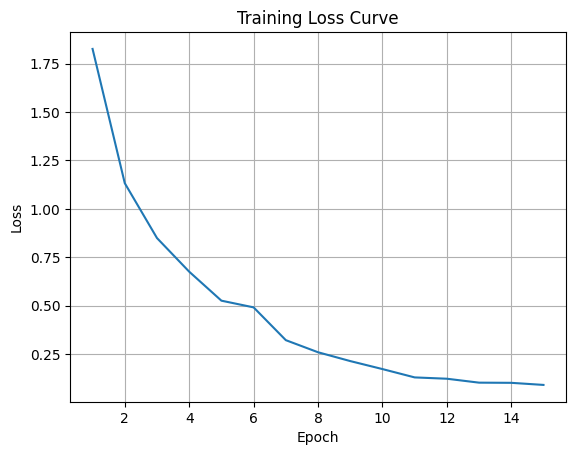

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/ferramenta/models'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
torch.save(resnet.state_dict(), save_path)

# Validation

In [ ]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
valPath = "/content/drive/MyDrive/Colab Notebooks/ferramenta/validImages/images-val"
val_dataset = ValidationDataset(valPath)
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
resnet.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet(images)
        
        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)
        
        # Store the predicted and true labels
        predicted_labels.extend(predicted_label.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

# # Convert the lists to PyTorch tensors on the same device
# predicted_labels = torch.tensor(predicted_labels, device=device)
# true_labels = torch.tensor(true_labels, device=device)


In [ ]:
# resnet.eval()

# # Initialize variables for evaluation
# total_samples = 0
# correct_predictions = 0
# true_positives = 0
# false_positives = 0
# false_negatives = 0

# with torch.no_grad():
#     for images, labels in validation_data_loader:
#         # Move the images and labels to the GPU if available
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = resnet(images)
        
#         # Get the predicted labels
#         _, predicted_labels = torch.max(outputs, 1)
        
#         # Update the total number of samples
#         total_samples += labels.size(0)
        
#         # Update the number of correct predictions
#         correct_predictions += (predicted_labels == labels).sum().item()
        
#         # Calculate the true positives, false positives, and false negatives
#         true_positives += ((predicted_labels == 1) & (labels == 1)).sum().item()
#         false_positives += ((predicted_labels == 1) & (labels == 0)).sum().item()
#         false_negatives += ((predicted_labels == 0) & (labels == 1)).sum().item()

Accuracy: 0.8436
Precision: 0.9954
Recall: 0.9943
F1 Score: 0.9949


In [ ]:
# # Calculate the accuracy
# accuracy = correct_predictions / total_samples

# # Calculate the precision, recall, and F1 score
# precision = true_positives / (true_positives + false_positives)
# recall = true_positives / (true_positives + false_negatives)
# f1_score = 2 * (precision * recall) / (precision + recall)

# # Print the evaluation metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1_score:.4f}")

In [ ]:
# Convert the tensors to numpy arrays
# predicted_labels = predicted_labels.cpu().numpy()
# true_labels = true_labels.cpu().numpy()

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8300601556970983
Precision: 0.8300601556970983
Recall: 0.8300601556970983
F1-score: 0.8300601556970983


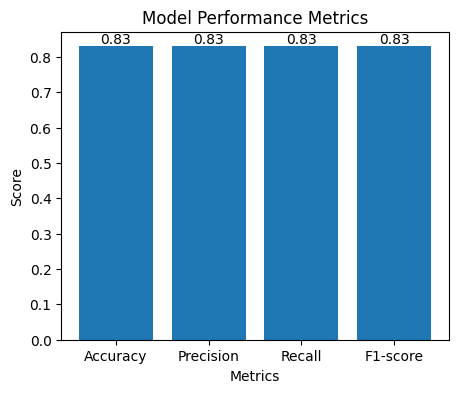

In [ ]:
# Assuming you have the accuracy, precision, recall, and F1-score values computed and stored in variables

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Write scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()


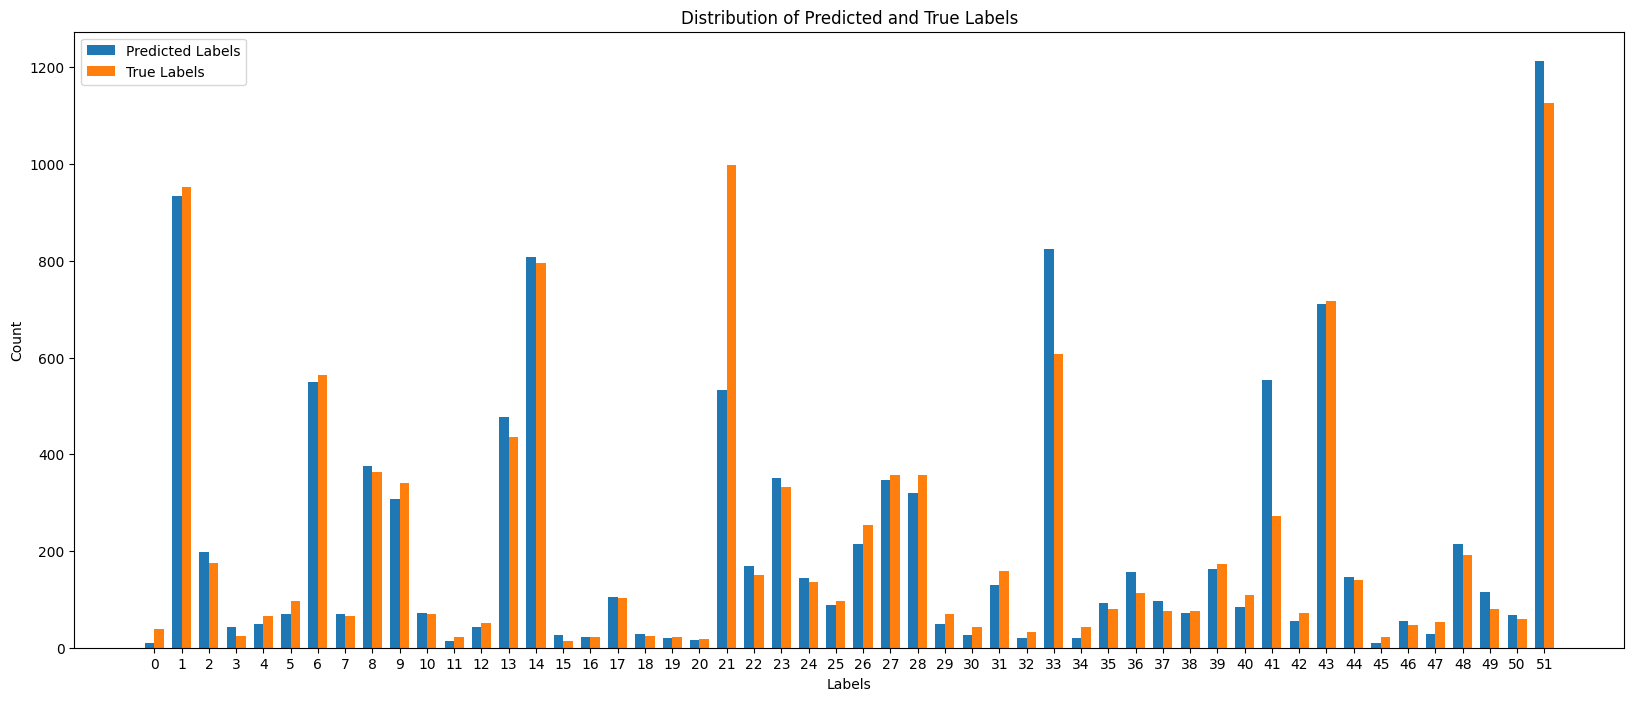

In [ ]:
# Assuming you have the predicted labels stored in a variable named 'predicted_labels'
# and the true labels stored in a variable named 'true_labels'

# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Visualization

In [ ]:
true_negatives = total_samples - correct_predictions - false_positives - false_negatives
confusion_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

print("Confusion Matrix:")
print(confusion_matrix)


Confusion Matrix:
[[1759    4]
 [   5  870]]


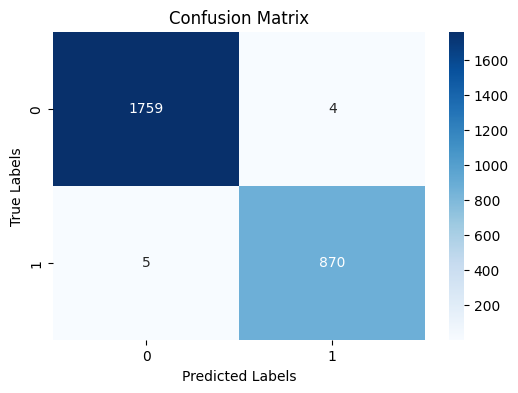

In [ ]:
plt.figure(figsize=(6, 4))
labels = []
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
class_names = data_loader.dataset.dataset.classes
class_performance = {"Precision": precision, "Recall": recall, "F1 Score": f1_score}
class_performance_df = pd.DataFrame(class_performance, index=range(len(class_names)))

print(class_names)

['@accessori_saldatore', '@accessori_trapano', '@armadio_cassettiera', '@bancale_cargo', '@banco', '@brugola', '@cacciavite_giravite_cercafase', '@carrello', '@carta-vetrata_carta-abrasiva', '@cassaforte', '@catena', '@cazzuola_frattone', '@cerniera_bandella', '@chiave-a-bussola_tubo', '@chiave_inglese_poligonale', '@chiavistello', '@chiodo_rivetto', '@colla_silicone', '@collare', '@coltello', '@estrattore', '@forbice_cesoia', '@lama_seghetto_sega', '@lame_sega_circolare', '@lima_grattuggia_raspa', '@livella', '@lucchetto', '@maniglia_pomello', '@martello_mazzetta_ascia', '@metro_flessometro', '@morsetto_strettoio', '@nastro', '@pennello', '@pinza_punzonatrice_giratubo', '@pinzetta', '@pistola', '@rubinetto_miscelatore_valvola', '@ruota', '@scaffale', '@scala', '@scalpello', '@sega-a-tazza', '@seghetto_sega', '@segnaletica', '@serratura_cilindro', '@spatola_raschietto', '@spazzola', '@staffa_squadretta', '@tassello', '@torcia-faro', '@vernice', '@vite_bullone']


In [ ]:
# Iterate over each class and plot the performance metrics individually
for i, class_name in enumerate(class_names):
    # Create a figure for each class
    fig, ax = plt.subplots(figsize=(2, ))
    
    # Get the performance metrics for the current class
    precision = class_performance_df.loc[class_name, "Precision"]
    recall = class_performance_df.loc[class_name, "Recall"]
    f1_score = class_performance_df.loc[class_name, "F1 Score"]
    
    # Plot the performance metrics for the current class
    x = ["Precision", "Recall", "F1 Score"]
    y = [precision, recall, f1_score]
    ax.bar(x, y)
    ax.set_title(f"Performance Metrics - {class_name}")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Score")
    ax.set_ylim([0, 1])  # Set the y-axis limit to [0, 1] for consistency
    
    plt.show()


# GoogleNet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image

In [ ]:
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 48.9MB/s]


In [ ]:
num_classes = len(data_loader.dataset.dataset.classes)  
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 15

In [ ]:
training_losses = []
googlenet.train()
# Loop over the dataset and train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = googlenet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader.dataset)
    training_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/15 Loss: 0.0597
Epoch 2/15 Loss: 0.0320
Epoch 3/15 Loss: 0.0226
Epoch 4/15 Loss: 0.0171
Epoch 5/15 Loss: 0.0132
Epoch 6/15 Loss: 0.0103
Epoch 7/15 Loss: 0.0080
Epoch 8/15 Loss: 0.0062
Epoch 9/15 Loss: 0.0048
Epoch 10/15 Loss: 0.0038
Epoch 11/15 Loss: 0.0030
Epoch 12/15 Loss: 0.0025
Epoch 13/15 Loss: 0.0021
Epoch 14/15 Loss: 0.0017
Epoch 15/15 Loss: 0.0013


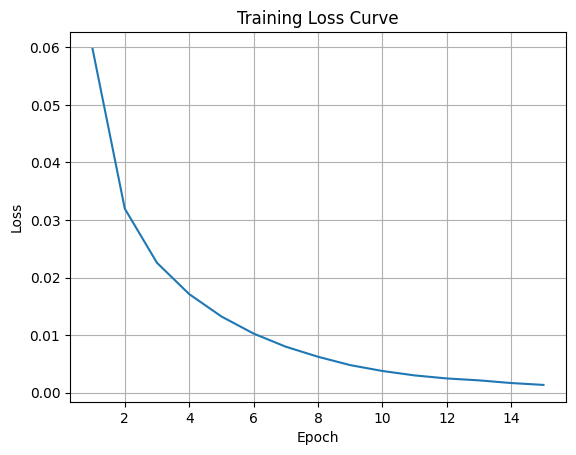

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [ ]:
# Initialize counters
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0

# Evaluation loop
googlenet.eval()
with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = googlenet(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        true_positives += torch.sum(predicted == labels).item()
        false_positives += torch.sum(predicted > labels).item()
        false_negatives += torch.sum(predicted < labels).item()
        true_negatives += torch.sum(predicted != labels).item()

In [ ]:
# Calculate the accuracy
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

# Calculate the precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8976
Precision: 0.9416
Recall: 0.9375
F1 Score: 0.9395


In [ ]:
confusion_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[ 1289   621]
 [  668 10015]]


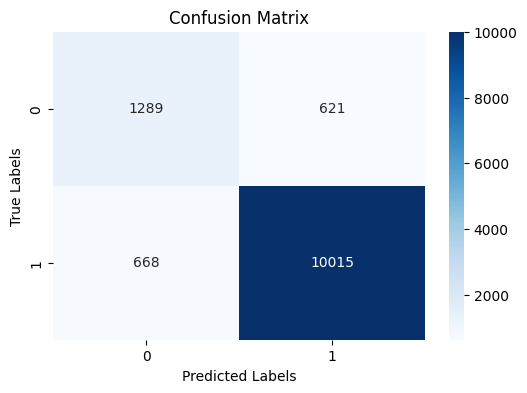

In [ ]:
plt.figure(figsize=(6, 4))
labels = []
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

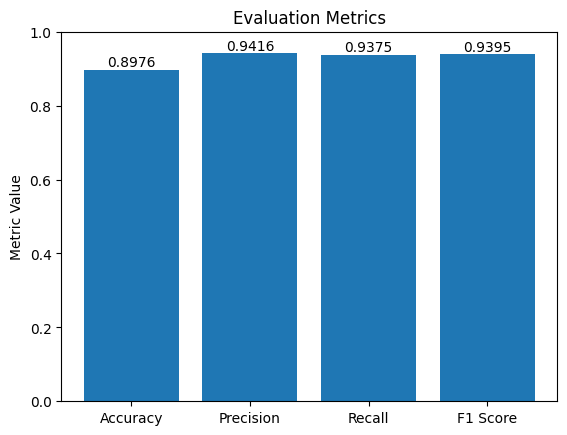

In [ ]:
# Define the labels for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the values for each metric
values = [accuracy, precision, recall, f1_score]

fig, ax = plt.subplots()
bars = ax.bar(metrics, values)
plt.ylim([0, 1])  # Set the y-axis limit to range from 0 to 1
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics')

# Add the metric scores on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()